# Dog Breed Identification : Modèle Xception

Nous allons utiliser le modèle Xception de la bibliothèque `tensorflow.keras.applications` sur des données importées avec le module `data_prep` en ajustant quelques hyper-paramètres.

## Préparation de l'environnement du travail

### Importation des packages

In [1]:
from data_prep import load_data
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.xception import Xception
import pickle

Regardons combien de GPUs disponible (que nous pouvons utiliser)

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### Dézipper le fichier de données

In [ ]:
zip_ref = zipfile.ZipFile("dog-breed-identification.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

### Récupération des données

Les données sont en deux parties: 
1. Le ficher `labels.csv` qui contient les `id` des images (le nom de fichier image sans extension) liés à leur modalité `breed`.
2. Le dossier `train` avec les images en format jpg.

Commençant par ajouter l'extension `.jpg` aux id des images dans `labels.csv` pour faciliter les tâches par la suite.

In [2]:
def append_ext(fn):
  return fn+".jpg"

In [3]:
df_train = pd.read_csv("/tmp/labels.csv")
df_train['id'] = df_train['id'].apply(append_ext)
df_train = df_train.set_index('id')
labelNames = df_train["breed"].unique()
labelNames.shape

(120,)

Nous avons 120 types de chiens (120 modalités), et 10222 images dans le dossier train.

In [4]:
df_train.head()

breed
id                                                    
000bec180eb18c7604dcecc8fe0dba07.jpg       boston_bull
001513dfcb2ffafc82cccf4d8bbaba97.jpg             dingo
001cdf01b096e06d78e9e5112d419397.jpg          pekinese
00214f311d5d2247d5dfe4fe24b2303d.jpg          bluetick
0021f9ceb3235effd7fcde7f7538ed62.jpg  golden_retriever

Ensuite, nous allons encoder ces modalités grâce à `LabelEncoder` pour avoir des nombres au lieu des chaînes de caractères :

In [5]:
le = LabelEncoder()
le.fit(df_train['breed'])
df_train['y'] = le.transform(df_train['breed'])
np.save('classes_le.npy', le.classes_)

Nous sauvegardons cet objet `LabelEncoder` pour l'utiliser sur les données test.

## Création du modèle (train/dev/test)

Avant de passer à l'entraînement, nous allons formatez les images en `tensors` à virgule flottante en les prétraitant de la manière suivante :

1.   Lire les images du disque.
2.   Décoder le contenu de ces images et le convertir au format de grille approprié selon leur contenu RGB.
3.   Convertir les en `tensors` à virgule flottante des valeurs entre 0 et 255 à des valeurs comprises entre 0 et 1.
4.   Redimensionnez les images.

Le module `data_prep` créé dans le cadre de ce projet, contient la fonction pour `load_data` qui permet d'avoir les images en format souhaité.

In [6]:
PATH = "/tmp/"
IMG_SIZE = 299
trainX,testX,trainY,testY = load_data(df_train,PATH=PATH,IMG_SIZE=IMG_SIZE,flip=True)

La taille des images est fixé à 299 et le paramètre `flip` de `load_data` permet de augmenter la taille de jeu de données en ajoutant des nouveux images avec un enversement horizontal des anciens.

In [7]:
trainX.shape

(13629, 299, 299, 3)

In [8]:
testX.shape

(6815, 299, 299, 3)

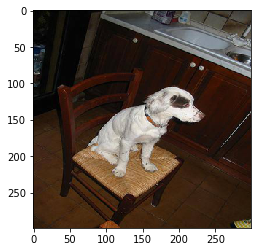

In [9]:
plt.imshow(trainX[5121])

### Hyper-paramètres

Fixant quelques hyper-paramètres et les variables qui seront utilisés pour l'entraînement :

In [11]:
batch_size = 40
epochs = 15
learning_rate = 0.001
m = trainX.shape[0]
input_shape = (IMG_SIZE, IMG_SIZE, trainX.shape[-1])
num_classes = labelNames.shape[0]

Nous n'allons pas pouvoir malheuresement normaliser les données, car nous ne poussédons pas du matériel pour le type `float32`.

In [12]:
# scale data to the range of [0, 1]
#trainX = trainX.astype("float32") / 255.0
#testX = testX.astype("float32") / 255.0

### Création du réseau de neurones `Xception`

In [13]:
modelXception = Xception(weights = None,input_shape=input_shape, pooling='max', classes=120)
modelXception.summary()

W0215 17:56:52.936657 139956868151104 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Choisissons `accuracy` comme metrique et `Adam` comme optimisateur, avec learning_rate = 0.001 : 

In [14]:
opt = Adam(lr=learning_rate)

modelXception.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Entraînement du modèle : 

In [16]:
historyXception = modelXception.fit(trainX, trainY, batch_size = 40, epochs = epochs, verbose=1,
                                    validation_split=0.20)

Train on 12266 samples, validate on 1363 samples
Epoch 1/15
12266/12266 [==============================] - 404s 33ms/sample - loss: 4.7148 - acc: 0.0205 - val_loss: 4.7831 - val_acc: 0.0051
Epoch 2/15
12266/12266 [==============================] - 402s 33ms/sample - loss: 4.3659 - acc: 0.0457 - val_loss: 17.5840 - val_acc: 0.0073
Epoch 3/15
12266/12266 [==============================] - 402s 33ms/sample - loss: 4.0296 - acc: 0.0712 - val_loss: 8.9044 - val_acc: 0.0315
Epoch 4/15
12266/12266 [==============================] - 402s 33ms/sample - loss: 3.7567 - acc: 0.1030 - val_loss: 4.7157 - val_acc: 0.0631
Epoch 5/15
12266/12266 [==============================] - 402s 33ms/sample - loss: 3.4473 - acc: 0.1518 - val_loss: 4.6659 - val_acc: 0.0961
Epoch 6/15
12266/12266 [==============================] - 402s 33ms/sample - loss: 3.0903 - acc: 0.2190 - val_loss: 4.6397 - val_acc: 0.1196
Epoch 7/15
12266/12266 [==============================] - 402s 33ms/sample - loss: 2.6915 - acc: 0.2935 

In [24]:
modelXception.save("models/Xception/modelXception1-1.h5")
with open('models/Xception/modelXception1-1HistoryDict', 'wb') as file_pi:
        pickle.dump(historyXception.history, file_pi)

In [11]:
loss, acc = modelXception.evaluate(trainX, trainY)
print(acc * 100)

13629/13629 [==============================] - 216s 16ms/sample - loss: 5.8115 - acc: 0.3217
32.166704535484314


In [12]:
loss, acc = modelXception.evaluate(testX, testY)
print(acc * 100)

6815/6815 [==============================] - 105s 15ms/sample - loss: 5.8531 - acc: 0.3338
33.382245898246765


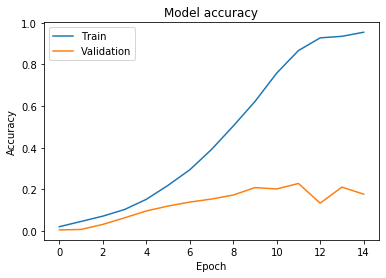

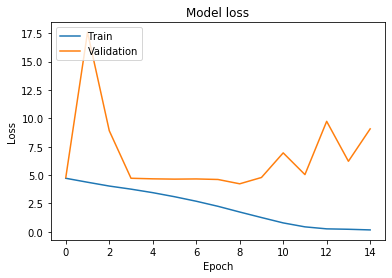

In [19]:
plt.plot(historyXception.history['acc'])
plt.plot(historyXception.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(historyXception.history['loss'])
plt.plot(historyXception.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Création du modèle (train/dev)

In [22]:
allTrainX = np.concatenate((trainX,testX), axis=0)
allTrainY = np.concatenate((trainY,testY), axis=0)

In [25]:
modelXception2 = Xception(weights = None,input_shape=input_shape, pooling='max', classes=120)
modelXception2.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [26]:
opt = Adam(lr=0.001)

modelXception2.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
historyXception2 = modelXception2.fit(allTrainX, allTrainY, 
                                      batch_size = 40, epochs = 15, verbose=1,validation_split=0.20)

Train on 16355 samples, validate on 4089 samples
Epoch 1/15
16355/16355 [==============================] - 558s 34ms/sample - loss: 4.6410 - acc: 0.0248 - val_loss: 4.7492 - val_acc: 0.0132
Epoch 2/15
16355/16355 [==============================] - 550s 34ms/sample - loss: 4.1349 - acc: 0.0667 - val_loss: 4.4203 - val_acc: 0.0440
Epoch 3/15
16355/16355 [==============================] - 551s 34ms/sample - loss: 3.7298 - acc: 0.1134 - val_loss: 4.5552 - val_acc: 0.0729
Epoch 4/15
16355/16355 [==============================] - 555s 34ms/sample - loss: 3.2970 - acc: 0.1787 - val_loss: 3.5573 - val_acc: 0.1675
Epoch 5/15
16355/16355 [==============================] - 552s 34ms/sample - loss: 2.8069 - acc: 0.2685 - val_loss: 3.8088 - val_acc: 0.1433
Epoch 6/15
16355/16355 [==============================] - 551s 34ms/sample - loss: 2.2887 - acc: 0.3785 - val_loss: 3.6493 - val_acc: 0.2211
Epoch 7/15
16355/16355 [==============================] - 549s 34ms/sample - loss: 1.8190 - acc: 0.4836 -

In [28]:
modelXception2.save("storage/Xception/modelXception1-2.h5")
with open('storage/Xception/modelXception1-2HistoryDict', 'wb') as file_pi:
        pickle.dump(historyXception2.history, file_pi)

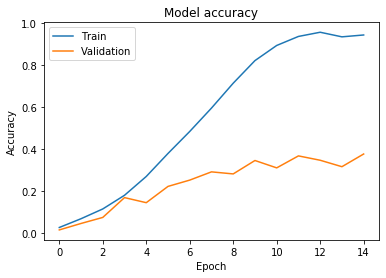

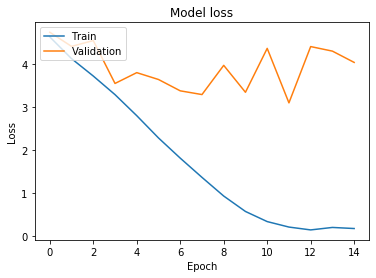

In [29]:
plt.plot(historyXception2.history['acc'])
plt.plot(historyXception2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(historyXception2.history['loss'])
plt.plot(historyXception2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()